In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_model = MobileNetV2(weights = 'imagenet',include_top = False , input_shape=(224,224,3))

In [3]:
base_model.trainable = False

In [4]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = 'relu')(x)
predictions = Dense(5,activation = 'softmax')(x)

In [5]:
model = Model(inputs = base_model.input , outputs = predictions)

In [6]:
model.compile (optimizer = Adam(learning_rate = 0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [7]:
datagen = ImageDataGenerator(rescale = 1. / 255 ,
                             validation_split = 0.3 ,
                             horizontal_flip = True,
                             zoom_range = 0.2,
                             shear_range = 0.2
                             )

In [9]:
train_datagenerator = datagen.flow_from_directory(
    r"D:\datasets\DL\flowers\train",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training' #set as traning data    
)

Found 2277 images belonging to 5 classes.


In [10]:
validation_generator = datagen.flow_from_directory(
    r"D:\datasets\DL\flowers\test",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 157 images belonging to 5 classes.


In [11]:
model.fit(train_datagenerator ,
          epochs = 10 ,
          validation_data = validation_generator)

Epoch 1/10


C:\Users\Tanmay LImje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 606ms/step - accuracy: 0.6697 - loss: 0.8615 - val_accuracy: 0.8217 - val_loss: 0.5081
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 340ms/step - accuracy: 0.8651 - loss: 0.3852 - val_accuracy: 0.8535 - val_loss: 0.3688
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 326ms/step - accuracy: 0.9059 - loss: 0.2642 - val_accuracy: 0.8344 - val_loss: 0.3863
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 332ms/step - accuracy: 0.9367 - loss: 0.1993 - val_accuracy: 0.8217 - val_loss: 0.4952
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.9204 - loss: 0.2100 - val_accuracy: 0.8917 - val_loss: 0.2974
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 331ms/step - accuracy: 0.9479 - loss: 0.1500 - val_accuracy: 0.8599 - val_loss: 0.3947
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 334ms/step - accuracy: 0.9563 - loss: 0.1340 - val_accuracy: 0.8790 - val_loss: 0.3721
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 330ms/step - accuracy: 0.9659 - loss: 0.1068 - val_accuracy: 0.840

In [12]:
test_loss ,  test_acc = model.evaluate(validation_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.9058 - loss: 0.2805


In [13]:
x_val , y_val = next(validation_generator)
predictions = model.predict(x_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


In [14]:
predicted_labels = np.argmax(predictions , axis=1)

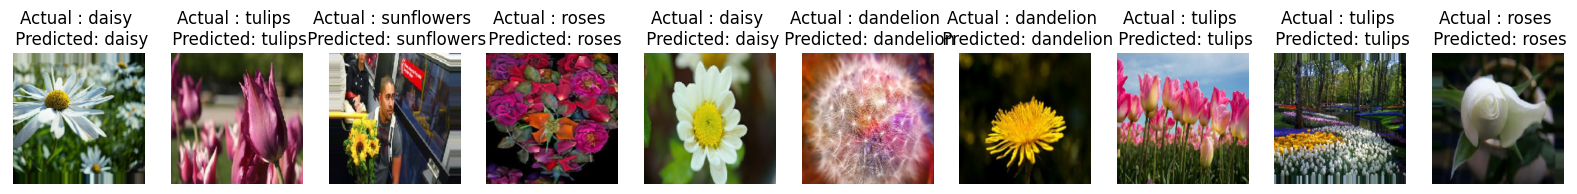

In [15]:
class_labels = list(train_datagenerator.class_indices.keys())

n = 10

plt.figure(figsize=(20,6))
for i in range(n):
    ax = plt.subplot(2, n , i+1)
    plt.imshow(x_val[i])

    actual_label = class_labels[np.argmax(y_val[i])]
    predicted_label = class_labels[predicted_labels[i]]

    plt.title(f"Actual : {actual_label} \n Predicted: {predicted_label}")
    plt.axis('off')
plt.show()